In [1]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *
from albumentations import (
    Compose,GaussianBlur,HorizontalFlip,MedianBlur,MotionBlur,OneOf,
    RandomBrightness,RandomContrast,Resize,ShiftScaleRotate,VerticalFlip,
    CoarseDropout,GridDistortion,ElasticTransform,OpticalDistortion
    )
import cv2

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [4]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']

        return PILImage.create(aug_img)

In [5]:
image_size = [224, 224]
def get_train_aug(image_size): return Compose(
    [
        Resize(height=image_size[0], width=image_size[1]),
        OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]), #fastai has
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
        OneOf([GridDistortion(),ElasticTransform(),OpticalDistortion()],p=0.5),
        VerticalFlip(p=0.5),#Dihedral
        HorizontalFlip(p=0.5),
        CoarseDropout(min_width=10,min_height=10,max_width=20,max_height=20),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=180,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
    ])

def get_valid_aug(image_size): return  Compose(
    [
        Resize(height=image_size[0], width=image_size[1]),
    ])

In [6]:
item_tfms = [AlbumentationsTransform(get_train_aug(image_size), get_valid_aug(image_size))]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = item_tfms,
                 batch_tfms=batch_tfms)
dls = db.dataloaders(trainPath,bs=32)

In [8]:
class MixedPrecision(Callback):
    "Mixed precision training using Pytorch's `autocast` and `GradScaler`"
    order = 10
    def __init__(self, **kwargs): self.kwargs,self.autocast = kwargs,autocast()
    def before_fit(self): self.learn.scaler,self.scales = GradScaler(**self.kwargs),L()
    def before_batch(self): self.autocast.__enter__()
    def after_pred(self):
        if listify(self.pred)[0].dtype==torch.float16: self.learn.pred = to_float(self.pred)
    def after_loss(self): self.autocast.__exit__()
    def before_backward(self): self.learn.loss_grad = self.scaler.scale(self.loss_grad)
    def before_step(self):
        self.skipped=True
        self.scaler.step(self)
        if self.skipped: raise CancelStepException()
        self.scales.append(self.scaler.get_scale())
    def after_step(self): self.learn.scaler.update()

    @property # pretend to be an optimizer for `GradScaler`
    def param_groups(self): return self.opt.param_groups
    def step(self, *args, **kwargs): self.skipped=False

class GradientClip(Callback):
    "Clip norm of gradients"
    order=MixedPrecision.order+1
    def __init__(self,max_norm:float=1., norm_type:float=2.0): store_attr()
    def before_step(self): nn.utils.clip_grad_norm_(self.parameters(), self.max_norm, self.norm_type)


In [9]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=10),
    SaveModelCallback(fname='vit'),
    MixUp(),GradientClip
]

In [10]:
import timm
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [11]:
learn = Learner(dls,ViTBase16(2,True),metrics=[accuracy,Precision(),Recall()],cbs=callbacks,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.726766,0.694122,0.513761,0.000000,0.000000,00:38


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


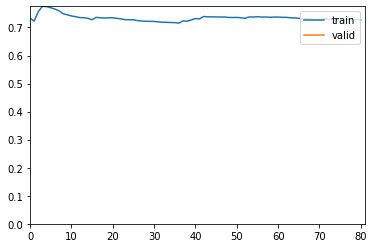

Better model found at epoch 0 with valid_loss value: 0.6941218972206116.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.699973,0.692629,0.513761,0.000000,0.000000,00:40
1,0.695085,0.691628,0.507645,0.494652,0.581761,00:40
2,0.694267,0.690037,0.535168,0.517588,0.647799,00:39
3,0.692220,0.692452,0.512232,0.498795,0.650943,00:39
4,0.690332,0.688984,0.544343,0.540984,0.415094,00:39
5,0.692685,0.690429,0.515290,0.501792,0.440252,00:39
6,0.690925,0.692152,0.536697,0.514286,0.849057,00:39
7,0.693095,0.709710,0.493884,0.489891,0.990566,00:40
8,0.694568,0.687615,0.559633,0.551370,0.506289,00:39
9,0.692110,0.690555,0.536697,0.523220,0.531447,00:40


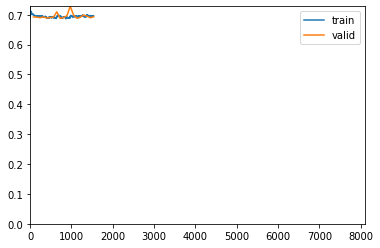

Better model found at epoch 0 with valid_loss value: 0.6926286220550537.
Better model found at epoch 1 with valid_loss value: 0.6916280388832092.
Better model found at epoch 2 with valid_loss value: 0.6900373697280884.
Better model found at epoch 4 with valid_loss value: 0.6889840960502625.
Better model found at epoch 8 with valid_loss value: 0.6876145005226135.
No improvement since epoch 8: early stopping


In [12]:
learn.fine_tune(100,reset_opt=True)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = item_tfms,
                 batch_tfms=batch_tfms)
dlsTest = dbTest.dataloaders(path,bs=32)

In [14]:
learn.cbs=[]

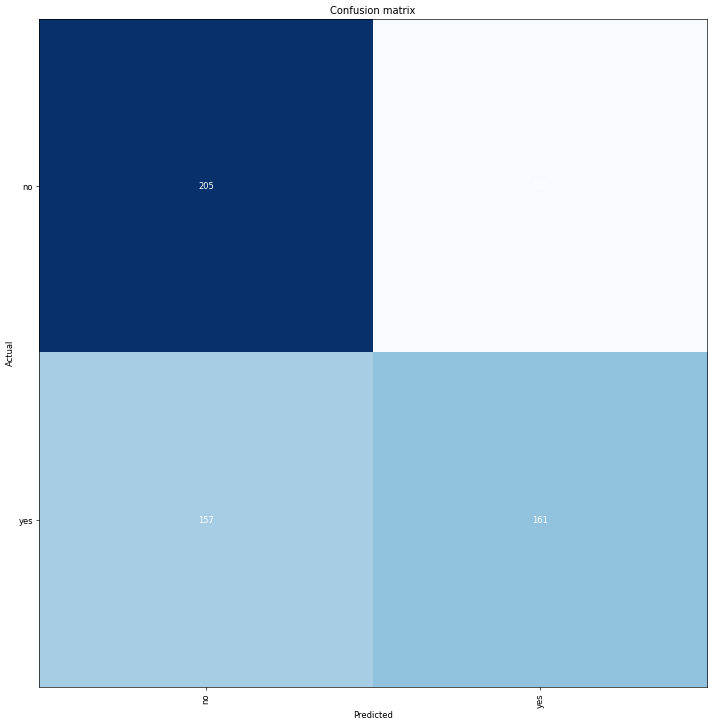

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

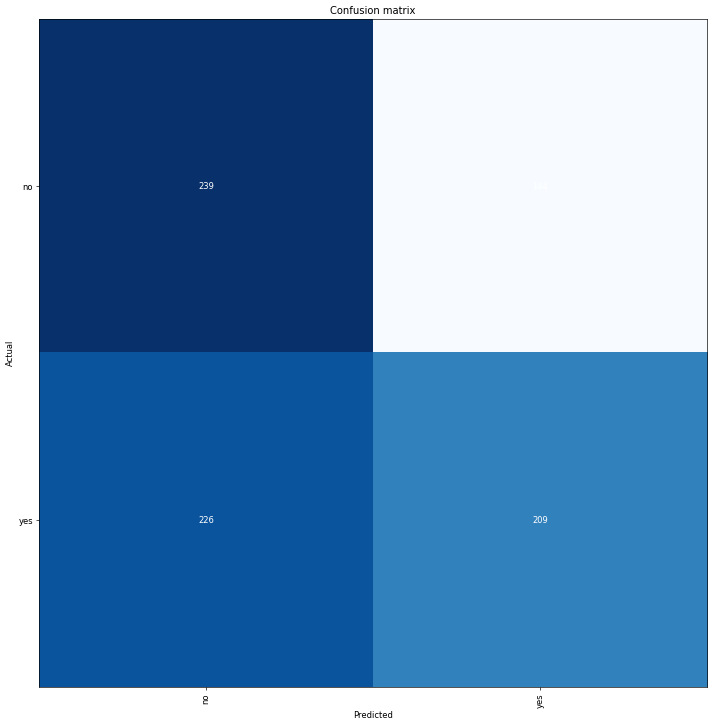

In [16]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)